***Author: Jarod Carroll***
# Predicting Ion Switching

**Data Source: https://www.kaggle.com/c/liverpool-ion-switching/data**

## Methodology
1. Data Acquisition
    - Download and unzip file from Kaggle
2. Data Inspection
    - Figure out what is important about the data
3. Data Preprocessing 
    - Transform the data to remove drift
    - Break the data into different waveforms
4. Modeling
    - Use a random forest model
    - Grade this model by submiting predictions to Kaggle
    - Keep Optimizing Model
        - Find new ways to preprocess data
        - Use different models
        - Evaluate with macro F1 by submiting to Kaggle
    
##### Import Packages

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import sys
import os
import time

from sklearn.model_selection import train_test_split, KFold, GroupKFold
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, StackingClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score

from keras.models import load_model

module_path = os.path.abspath(os.path.join(os.pardir, os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from src.transformers import LinearTransformation, ParabolicTransformation, TrigTransformation
from src.preprocessing import *
from src.sliding_window import *
from src.models import *
from src.helpers import *

%matplotlib inline
%load_ext autoreload
%autoreload 2

# Global Var
sliding_window_size = 20

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Data Acquisition

The data was downloaded from Kaggle and unzipped.

### Data Inspection
In order to understand the features of this data the time series was graphed and visually inspected. First the data was loaded into dataframes and then graphed.

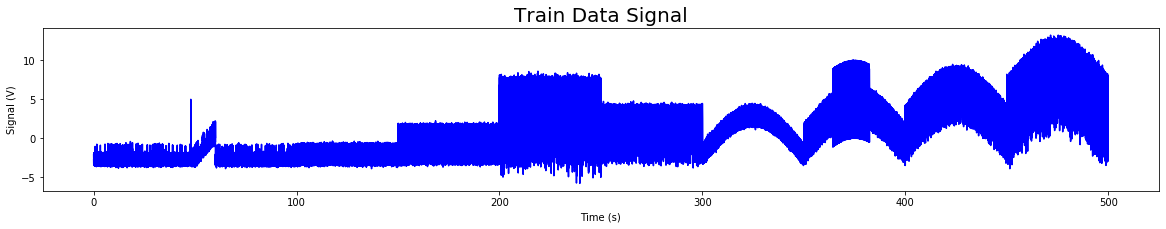

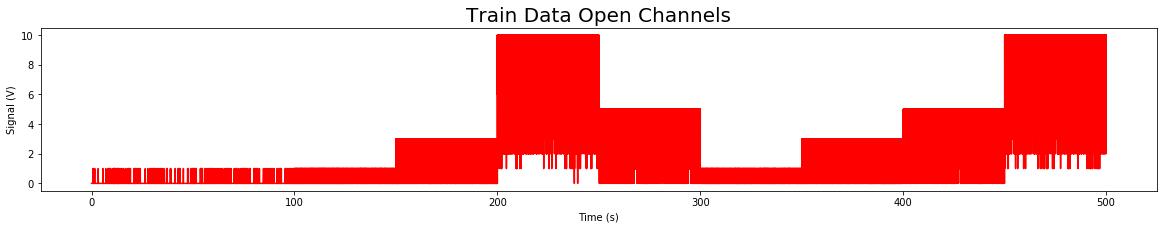

In [2]:
full_data = pd.read_csv('../../data/train.csv')
test_data = pd.read_csv('../../data/test.csv')

plt.figure(figsize = (20, 3))
plt.plot(full_data['time'], full_data['signal'], color = 'blue')
plt.xlabel('Time (s)', fontsize = 10)
plt.ylabel('Signal (V)', fontsize = 10)
plt.title("Train Data Signal", fontsize = 20)

plt.figure(figsize = (20, 3))
plt.plot(full_data['time'], full_data['open_channels'], color = 'red')
plt.xlabel('Time (s)', fontsize = 10)
plt.ylabel('Signal (V)', fontsize = 10)
plt.title("Train Data Open Channels", fontsize = 20);

Things to note:
- The data is proken up into sections 0f 500,000 data point
- The recording is 10 kHz data
- In the signal data there are 2 types of drift. Linear drift and sine drift (this was first thought to be parabolic)
- In the open channels data there are 5 different forms based on how many channels they are recording and what type they are.
    1. 1 slow ion channel
    2. 1 fast ion channel
    3. 3 ion channels
    4. 5 ion channels
    5. 10 ion channels
This data was broken into 50 second chunks because they each chunk is a different recording.

The same characteristics can be seen in the test data.

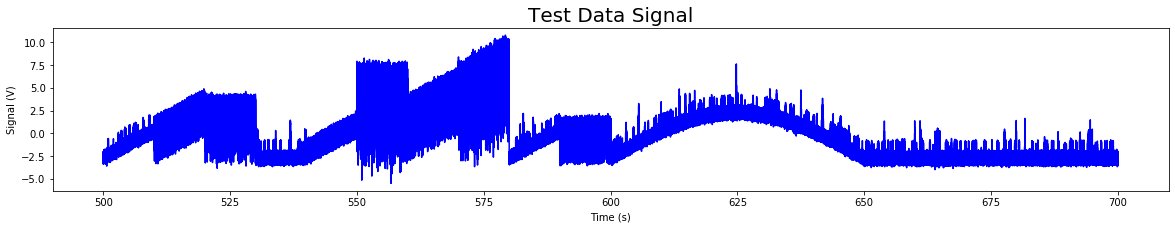

In [3]:
plt.figure(figsize = (20, 3))
plt.plot(test_data['time'], test_data['signal'], color = 'blue')
plt.xlabel('Time (s)', fontsize = 10)
plt.ylabel('Signal (V)', fontsize = 10)
plt.title("Test Data Signal", fontsize = 20);

### Data Preprocessing
The data was chunked into their respective waveforms and the drifts were removed.

In [8]:
train_chunks = chunk_data(full_data, 10)
test_chunks = chunk_data(test_data, 4)
test_chunks = chunk_data(test_chunks[0], 5) + chunk_data(test_chunks[1], 5) + test_chunks[2:]

train_chunks = transform_train_chunks(train_chunks)
test_chunks = transform_test_chunks(test_chunks);

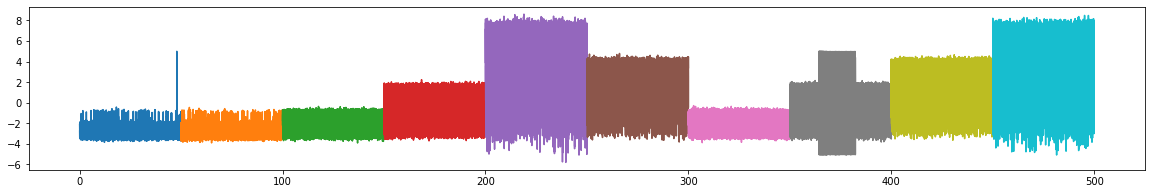

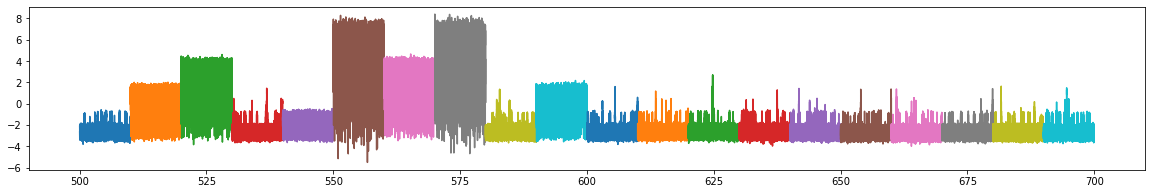

In [9]:
plt.figure(figsize = (20, 3))
for chunk in train_chunks:
    plt.plot(chunk['time'], chunk['signal'])
    
plt.figure(figsize = (20, 3))
for chunk in test_chunks:
    plt.plot(chunk['time'], chunk['signal'])

### Modeling
The first attempt at modeling this was by using a random forest in order to classify the number of channels open. Five models were made with each one being used for a different waveform. Each model was trained on their respective waveforms and then the test data was assigned a waveform and predictions were made. This same process was repeated using different models to find the model that fit the test data the best.

In order to score our model the predictions were submited to Kaggle in a CSV and an macro F1 score is received. 

The first model using a random forest once optimized got a score of 0.92.

In order to improve this model to a 0.94 a neural network was used. Once tuned these models were saved for future predictions

In [10]:
model1 = load_model('../../data/models/NN_model1.h5')
model2 = load_model('../../data/models/NN_model2.h5')
model3 = load_model('../../data/models/NN_model3.h5')
model4 = load_model('../../data/models/NN_model4.h5')
model5 = load_model('../../data/models/NN_model5.h5')

In [16]:
predictions = pd.DataFrame(columns = ['time', 'open_channels'])
predictions = pd.concat([predictions, predict(model1, test_chunks[0])])
predictions = pd.concat([predictions, predict(model3, test_chunks[1])])
predictions = pd.concat([predictions, predict(model4, test_chunks[2])])
predictions = pd.concat([predictions, predict(model1, test_chunks[3])])
predictions = pd.concat([predictions, predict(model2, test_chunks[4])])
predictions = pd.concat([predictions, predict(model5, test_chunks[5])])
predictions = pd.concat([predictions, predict(model4, test_chunks[6])])
predictions = pd.concat([predictions, predict(model5, test_chunks[7])])
predictions = pd.concat([predictions, predict(model1, test_chunks[8])])
predictions = pd.concat([predictions, predict(model3, test_chunks[9])])
predictions = pd.concat([predictions, predict(model1, test_chunks[10])])
predictions = pd.concat([predictions, predict(model1, test_chunks[11])])
predictions = pd.concat([predictions, predict(model1, test_chunks[12])])
predictions = pd.concat([predictions, predict(model1, test_chunks[13])])
predictions = pd.concat([predictions, predict(model1, test_chunks[14])])
predictions = pd.concat([predictions, predict(model1, test_chunks[15])])
predictions = pd.concat([predictions, predict(model1, test_chunks[16])])
predictions = pd.concat([predictions, predict(model1, test_chunks[17])])
predictions = pd.concat([predictions, predict(model1, test_chunks[18])])
predictions = pd.concat([predictions, predict(model1, test_chunks[19])])

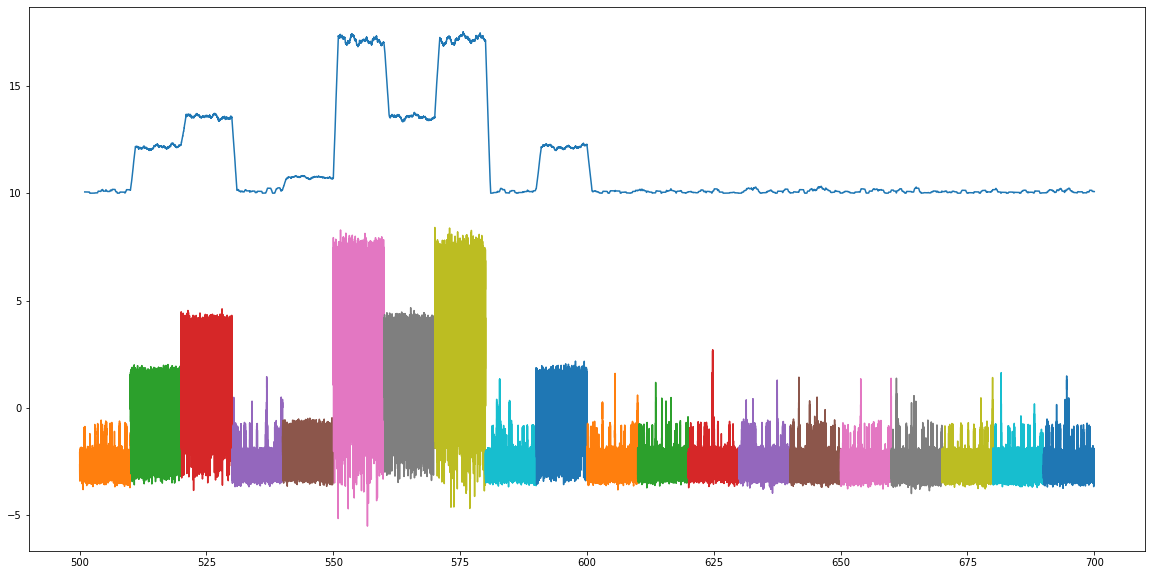

In [17]:
plt.figure(figsize = (20, 10))
plt.plot(predictions['time'], predictions['open_channels'].rolling(10000).mean() + 10)
for i in test_chunks:
    plt.plot(i['time'], i['signal'])